# Capillary pressure UserObjects #

Tests used for the capillary pressure UserObjects

Chris Green, 2015 (chris.green@csiro.au)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Constant ##

The *CapillaryPressureConstant* UserObject returns the given capillary pressure for all liquid saturations, i.e., $P_c = P_0$.

In [2]:
cols = ('pc', 'id', 'x', 'y', 'z')
pcc = pd.read_csv('gold/CapillaryPressureConstant_vpp_0001.csv', header = 0, names = cols)

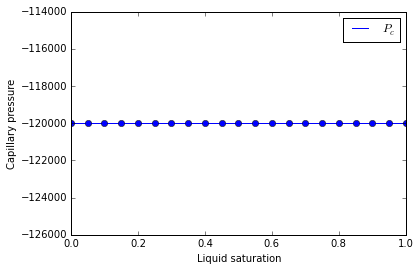

In [3]:
plt.plot(pcc.x, pcc.pc, label='$P_c$')
plt.plot(pcc.x, pcc.pc, 'ob')
plt.xlabel('Liquid saturation')
plt.ylabel('Capillary pressure')
plt.legend(loc='upper right')

## van Genuchten ##

The *CapillaryPressureVanGenuchten* UserObject implements the capillary pressure functions of van Genuchten, taken from *van Genuchten, M. Th., A closed for equation for predicting the hydraulic conductivity of unsaturated soils, Soil Sci. Soc., 44, 892-898 (1980)*. 

The effective saturation is defined as 
\begin{equation}
S^* = (S_l - S_{lr}) / (S_{ls} - S_{lr})
\end{equation}
where $S_l$ is the liquid saturation, $S_{lr}$ is the residual (or irreducable) liquid saturation, and $S_{ls}$ is the fully saturated liquid saturation.

The capillary pressure $P_c$ is given by
\begin{equation}
P_c = - P_0 \left( \left(S^* \right)^{-1/\lambda} - 1 \right)^{1-\lambda}
\end{equation}

Defining a function to calculate the van Genuchten form of the capillary pressure (as well as the first derivative).

In [348]:
def pcvg(Sl, Slr, Sls, m, p0) :

    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The capillary pressure is 
    pc = - p0 * np.power(np.power(S_star, -1.0/m) -1, 1.0-m)
   
    return pc

def dpcvg(Sl, Slr, Sls, m, p0) :
    
    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The derivative of Pc is
    dpc = p0 * (1.0 - m)/m * np.power(np.power(S_star, -1.0/m) - 1.0, -m) * np.power(S_star, (-m - 1.0)/m) / (Sls -Slr)
    
    return dpc

Note that this unmodified version of van Genuchtens capillary pressure curve has the following undesirable properties: 
* $P_c \to - \infty$ as $S_l \to S_{lr}$
* $\frac{d P_c}{d S_l} \to \infty$ as $S_l \to S_{ls}$

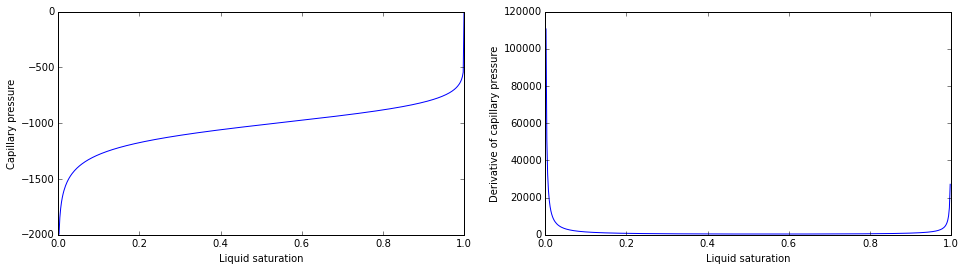

In [360]:
sdata = np.linspace(0,1,500)

fig, axes = plt.subplots(1,2, figsize = (16,4))
# Pc
axes[0].plot(sdata, pcvg(sdata, 0, 1, 0.9, 1e3))
axes[0].set_ylabel('Capillary pressure')
axes[0].set_xlabel('Liquid saturation')
# dPc/dSl
axes[1].plot(sdata, dpcvg(sdata, 0, 1, 0.9, 1e3))
axes[1].set_ylabel('Derivative of capillary pressure')
axes[1].set_xlabel('Liquid saturation')

As a result, we implement cubic spline extensions for low and high liquid saturations (near the residual and irreducible liquid saturations, respectively), effectively providing a low saturation cutoff in capillary pressure, and limiting the gradient at high saturations.


### Low $S_l$ cutoff ###

At values of $S_l$ near residual liquid saturation, the van Genuchten capillary pressure curve tends to - $\infty$. This is not physically realistic, so a maximum cutoff is applied. However, to avoid discontinuties in the derivative of the capillary pressure curve, rather than a hard cutoff, we implement a cubic spline interpolant to make the capillary pressure curve continuous and smooth for values of liquid saturation at or below residual liquid saturation.


This function determines the point where the capillary pressure curve meets the cutoff, and arbitrarily takes this point plus 0.01 as the point to create the cubic spline.

In [431]:
def Sc(Slr, Sls, m, p0, pmax) :
        
    sc = np.power(1.0 + np.power(pmax/p0, 1.0/(1.0-m)), -m)
    sc = sc * (Sls - Slr) + Slr
    sc += 0.02
    
    return sc

The cubic spline interpolation at low liquid saturation is then given by

In [432]:
def cubicspline1(S, pmax, S0, S2, pcS2, dpcS2) :
    a = (pcS2*S0**2 *(S0 - 3*S2) + S2*(pmax*S2*(-3*S0 + S2) + dpcS2*S0**2 *(-S0 + S2)))/(S0 - S2)**3
    b = (S0*(6*(pcS2 + pmax)*S2 + dpcS2*(S0 - S2)*(S0 + 2*S2)))/(S0 - S2)**3
    c = (-3*pcS2 *(S0 + S2) - 3*pmax *(S0 + S2) + dpcS2*(-2*S0**2 + S0*S2 + S2**2))/(S0 - S2)**3
    d = (2*pcS2 + 2*pmax + dpcS2 *(S0 - S2))/(S0 - S2)**3
    
    return a + b * S + c * S * S + d * S * S * S

The derivative of the cubic spline is

In [433]:
def dcubicspline1(S, pmax, S0, S2, pcS2, dpcS2) :
    b = (S0*(6*(pcS2 + pmax)*S2 + dpcS2*(S0 - S2)*(S0 + 2*S2)))/(S0 - S2)**3
    c = (-3*pcS2 *(S0 + S2) - 3*pmax *(S0 + S2) + dpcS2*(-2*S0**2 + S0*S2 + S2**2))/(S0 - S2)**3
    d = (2*pcS2 + 2*pmax + dpcS2 *(S0 - S2))/(S0 - S2)**3
    
    return b  + 2 *c * S + 3 *d * S * S


### High $S_l$ cutoff ###

At values of $S_l$ near residual irreducible saturation $S_{ls}$, the gradient of the van Genuchten capillary pressure curve can $ \to \infty$. This is can be problematic in numerical solutions, so we implement a cubic spline interpolant to make the capillary pressure curve continuous and smooth for values of liquid saturation near irreducible liquid saturation.

Like the cutoff at low $S_l$, we arbitrarily pick a saturation 0.01 less than S$_{ls}$ as the point where the cubic spline is fitted.

In [397]:
def cubicspline2(S, S3, S4, pcS3, dpcS3) :
      
    # The cubic spline coefficients
    a = (S4**2 *(pcS3*(3*S3 - S4) + dpcS3*S3*(-S3 + S4)))/(S3 - S4)**3
    b = (S4 *(6 *pcS3 *S3 + dpcS3 *(-2 *S3**2 + S3 *S4 + S4**2)))/(-S3 + S4)**3
    c = (3 *pcS3 *(S3 + S4) - dpcS3 *(S3 - S4) *(S3 + 2* S4))/(S3 - S4)**3
    d = (-2 *pcS3 + dpcS3 *(S3 - S4))/(S3 - S4)**3
    
    return a + b * S + c * S * S + d * S * S * S

The derivative of the cubic spline is

In [434]:
def dcubicspline2(S, S3, S4, pcS3, dpcS3) :
      
    # The cubic spline coefficients
    b = (S4 *(6 *pcS3 *S3 + dpcS3 *(-2 *S3**2 + S3 *S4 + S4**2)))/(-S3 + S4)**3
    c = (3 *pcS3 *(S3 + S4) - dpcS3 *(S3 - S4) *(S3 + 2* S4))/(S3 - S4)**3
    d = (-2 *pcS3 + dpcS3 *(S3 - S4))/(S3 - S4)**3
    
    return b + 2 *c * S  + 3 * d * S * S

### Modified van Genuchten capillary pressure curve ###

We can then define a modified van Genuchten capillary pressure curve with cubic spline interpolation at each end.

In [435]:
def pcvgm(Sl, Slr, Sls, m, p0, pmax) :

    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The point where the curve meets the cutoff
    S2 = Sc(Slr, Sls, m, p0, pmax)
    S0 = np.max([0,S2 - 2*0.02])
    
    # The high Sl spline point
    S3 = Sls - 0.02 
    S4 = np.min([1, S3 + 2*0.02])

    # The capillary pressure is 
    if Sl <= S0 :
        pc = -pmax
    elif S0 < Sl <= S2 :
        # Pc and dPc/dSl evaluated at S2
        pcS2 = pcvg(S2, Slr, Sls, m, p0)
        dpcS2 = dpcvg(S2, Slr, Sls, m, p0) 
        
        pc = cubicspline1(Sl, pmax, S0, S2, pcS2, dpcS2)
    elif S3 <= Sl <= S4 :
        # Pc and dPc/dSl evaluated at S3
        pcS3 = pcvg(S3, Slr, Sls, m, p0)
        dpcS3 = dpcvg(S3, Slr, Sls, m, p0) 
        
        pc = cubicspline2(Sl, S3, S4, pcS3, dpcS3)
    elif Sl > S4 :
        pc = 0
    else :
        pc = pcvg(Sl, Slr, Sls, m, p0)
   
    return pc

Similarly, the derivative $dP_c/dS_l$ can also be defined

In [436]:
def dpcvgm(Sl, Slr, Sls, m, p0, pmax) :

    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The point where the curve meets the cutoff
    S2 = Sc(Slr, Sls, m, p0, pmax)
    S0 = np.max([0,S2 - 2*0.02])
    
    # The high Sl spline point
    S3 = Sls - 0.02
    S4 = np.min([1, S3 + 2*0.02])

    # The derivative of the capillary pressure is 
    if Sl <= S0 :
        dpc = 0
    elif S0 < Sl <= S2 :
        # Pc and dPc/dSl evaluated at S2
        pcS2 = pcvg(S2, Slr, Sls, m, p0)
        dpcS2 = dpcvg(S2, Slr, Sls, m, p0) 
        
        dpc = dcubicspline1(Sl, pmax, S0, S2, pcS2, dpcS2)
    elif S3 <= Sl <= S4 :
        # Pc and dPc/dSl evaluated at S3
        pcS3 = pcvg(S3, Slr, Sls, m, p0)
        dpcS3 = dpcvg(S3, Slr, Sls, m, p0) 
        
        dpc = dcubicspline2(Sl, S3, S4, pcS3, dpcS3)
    elif Sl > S4 :
        dpc = 0
    else :
        dpc = dpcvg(Sl, Slr, Sls, m, p0)
   
    return dpc

Plot of the original and modified van Genuchten capillary pressure curves.

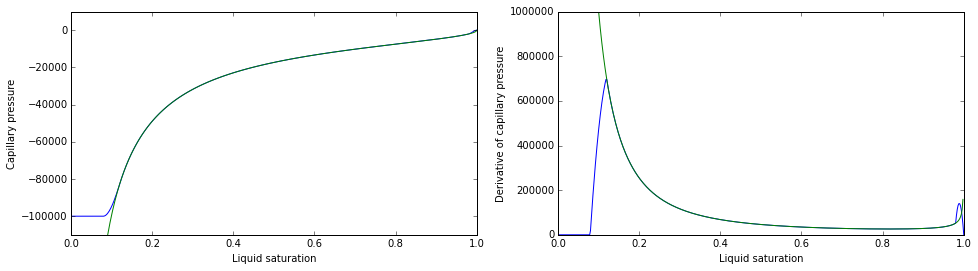

In [437]:
sdata = np.linspace(0,1,500)

pc = pcvg(sdata, 0, 1, 0.5, 1e4)

pcm = np.zeros(len(sdata))
dpcm = np.zeros(len(sdata))

for i in xrange(0,len(sdata)) :
    pcm[i] = pcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)
    dpcm[i] = dpcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)


fig, axes = plt.subplots(1,2, figsize = (16,4))
# Pc
axes[0].plot(sdata, pcm)
axes[0].plot(sdata, pc)
axes[0].set_ylim([-1.1e5,1e4])
axes[0].set_ylabel('Capillary pressure')
axes[0].set_xlabel('Liquid saturation')
# dPc/dSl
axes[1].plot(sdata, dpcm)
axes[1].plot(sdata, dpcvg(sdata, 0, 1, 0.5, 1e4))
axes[1].set_ylim([0, 1e6])
axes[1].set_ylabel('Derivative of capillary pressure')
axes[1].set_xlabel('Liquid saturation')

Plot the second derivative as well

In [408]:
def d2cubicspline1(S, pmax, S0, S2, pcS2, dpcS2) :
    c = (-3*pcS2 *(S0 + S2) - 3*pmax *(S0 + S2) + dpcS2*(-2*S0**2 + S0*S2 + S2**2))/(S0 - S2)**3
    d = (2*pcS2 + 2*pmax + dpcS2 *(S0 - S2))/(S0 - S2)**3
    
    return 2 *c  + 6 *d * S

In [409]:
def d2cubicspline2(S, S3, S4, pcS3, dpcS3) :
      
    # The cubic spline coefficients
    c = (3 *pcS3 *(S3 + S4) - dpcS3 *(S3 - S4) *(S3 + 2* S4))/(S3 - S4)**3
    d = (-2 *pcS3 + dpcS3 *(S3 - S4))/(S3 - S4)**3
    
    return 2 *c  + 6 * d * S

In [410]:
def d2pcvg(Sl, Slr, Sls, m, p0) :
    
    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The second derivative of Pc is
    a = np.power(S_star, -1.0/m) -1.0
    d2pc = p0 *(1.0-m)/m * (np.power(a,-1.0-m) * np.power(S_star, -2.0/m -2.0) - (1.0+m)/m * np.power(a, -m) * 
                            np.power(S_star, -1.0/m-2.0)) / (Sls-Slr)/(Sls-Slr)
    
    return d2pc

In [520]:
def d2pcvgm(Sl, Slr, Sls, m, p0, pmax) :

    # Calculate effective saturation
    S_star = np.clip((Sl - Slr)/(Sls - Slr),0,1)
    
    # The point where the curve meets the cutoff
    S2 = Sc(Slr, Sls, m, p0, pmax)
    S0 = np.max([0,S2 - 2*0.02])
    
    # The high Sl spline point
    S3 = Sls - 0.02
    S4 = np.min([1, S3 + 2*0.02])

    # The derivative of the capillary pressure is 
    if Sl <= S0 :
        d2pc = 0
    elif S0 < Sl < S2 :
        # Pc and dPc/dSl evaluated at S2
        pcS2 = pcvg(S2, Slr, Sls, m, p0)
        dpcS2 = dpcvg(S2, Slr, Sls, m, p0) 
        
        d2pc = d2cubicspline1(Sl, pmax, S0, S2, pcS2, dpcS2)
    elif S3 <= Sl <= S4 :
        # Pc and dPc/dSl evaluated at S3
        pcS3 = pcvg(S3, Slr, Sls, m, p0)
        dpcS3 = dpcvg(S3, Slr, Sls, m, p0) 
        
        d2pc = d2cubicspline2(Sl, S3, S4, pcS3, dpcS3)
    elif Sl > S4 :
        d2pc = 0
    else :
        d2pc = d2pcvg(Sl, Slr, Sls, m, p0)
   
    return d2pc

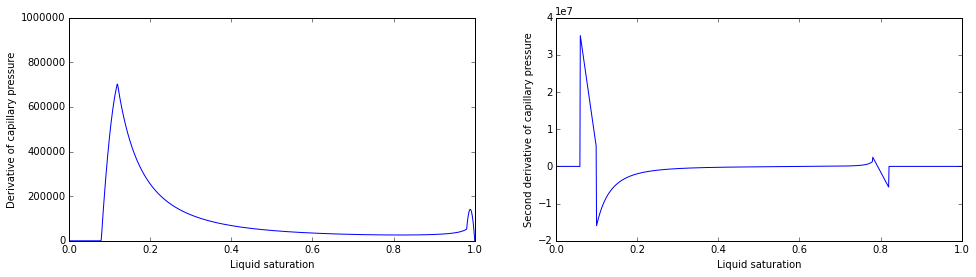

In [521]:
sdata = np.linspace(0,1,1000)

dpcm = np.zeros(len(sdata))
d2pcm = np.zeros(len(sdata))

for i in xrange(0,len(sdata)) :
    dpcm[i] = dpcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)
    d2pcm[i] = d2pcvgm(sdata[i], 0, 0.8, 0.5, 1e4, 1e5)


fig, axes = plt.subplots(1,2, figsize = (16,4))
# dPc/dSl
axes[0].plot(sdata, dpcm)
axes[0].set_ylim([0, 1e6])
axes[0].set_ylabel('Derivative of capillary pressure')
axes[0].set_xlabel('Liquid saturation')
# d2Pc/dSl2
axes[1].plot(sdata, d2pcm)
#axes[1].set_ylim([0, 1e6])
axes[1].set_ylabel('Second derivative of capillary pressure')
axes[1].set_xlabel('Liquid saturation')

In [481]:
sdata = np.linspace(0,1,500)

pcm1 = np.zeros(len(sdata))
pcm2 = np.zeros(len(sdata))
pcm3 = np.zeros(len(sdata))
pcm4 = np.zeros(len(sdata))

for i in xrange(0,len(sdata)) :
    pcm1[i] = pcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)
    pcm2[i] = pcvgm(sdata[i], 0.2, 1, 0.5, 1e4, 1e5)
    pcm3[i] = pcvgm(sdata[i], 0.1, 1, 0.95, 5e3, 1e4)
    pcm4[i] = pcvgm(sdata[i], 0.3, 0.8, 0.5, 1e4, 1e5)

Read in the data from the MOOSE tests for the van Genuchten capillary pressure.

In [490]:
cols = ('pc', 'id', 'x', 'y', 'z')
pcvg1 = pd.read_csv('gold/CapillaryPressureVanGenuchten1_vpp_0001.csv', header = 0, names = cols)
pcvg2 = pd.read_csv('gold/CapillaryPressureVanGenuchten2_vpp_0001.csv', header = 0, names = cols)
pcvg3 = pd.read_csv('gold/CapillaryPressureVanGenuchten3_vpp_0001.csv', header = 0, names = cols)
pcvg4 = pd.read_csv('gold/CapillaryPressureVanGenuchten4_vpp_0001.csv', header = 0, names = cols)

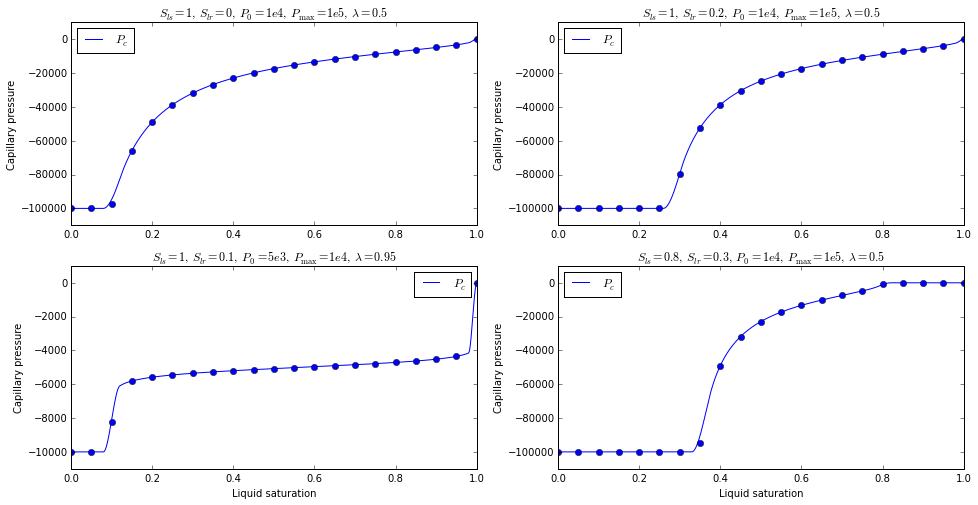

In [491]:
fig, axes = plt.subplots(2,2, figsize = (16,8))
# Case 1
axes[0,0].plot(sdata, pcm1, label = '$P_c$')
axes[0,0].plot(pcvg1.x, pcvg1.pc, 'ob')
axes[0,0].legend(loc = 'best')
axes[0,0].set_ylabel('Capillary pressure')
axes[0,0].set_title('$S_{ls}=1, \,S_{lr}=0, \,P_0=1e4, \, P_{\mathrm{max}}=1e5, \,\lambda = 0.5$')
axes[0,0].set_ylim([-1.1e5, 1e4]);
# Case 2
axes[0,1].plot(sdata, pcm2, label = '$P_c$')
axes[0,1].plot(pcvg2.x, pcvg2.pc, 'ob')
axes[0,1].legend(loc = 'best')
axes[0,1].set_ylabel('Capillary pressure')
axes[0,1].set_title('$S_{ls}=1, \,S_{lr}=0.2, \,P_0=1e4, \, P_{\mathrm{max}}=1e5, \,\lambda = 0.5$')
axes[0,1].set_ylim([-1.1e5, 1e4]);
# Case 3
axes[1,0].plot(sdata, pcm3, label = '$P_c$')
axes[1,0].plot(pcvg3.x, pcvg3.pc, 'ob')
axes[1,0].legend(loc = 'best')
axes[1,0].set_xlabel('Liquid saturation')
axes[1,0].set_ylabel('Capillary pressure')
axes[1,0].set_title('$S_{ls}=1, \,S_{lr}=0.1, \,P_0=5e3, \, P_{\mathrm{max}}=1e4, \,\lambda = 0.95$')
axes[1,0].set_ylim([-1.1e4, 1e3]);
# Case 4
axes[1,1].plot(sdata, pcm4, label = '$P_c$')
axes[1,1].plot(pcvg4.x, pcvg4.pc, 'ob')
axes[1,1].legend(loc = 'best')
axes[1,1].set_xlabel('Liquid saturation')
axes[1,1].set_ylabel('Capillary pressure')
axes[1,1].set_title('$S_{ls}=0.8, \,S_{lr}=0.3, \,P_0=1e4, \, P_{\mathrm{max}}=1e5, \,\lambda = 0.5$')
axes[1,1].set_ylim([-1.1e5, 1e4]);

Verify that the derivative of the capillary pressure with respect to liquid saturation is evaluated correctly using the results for case 1 above.

In [524]:
sdata = np.linspace(0,1,500)

dpcm1 = np.zeros(len(sdata))

for i in xrange(0,len(sdata)) :
    dpcm1[i] = dpcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)

Read in the data from the MOOSE tests for the van Genuchten capillary pressure.

In [525]:
cols = ('dpc', 'id', 'x', 'y', 'z')
dpcvg1 = pd.read_csv('gold/CapillaryPressureVanGenuchten_dpc1_vpp_0001.csv', header = 0, names = cols)

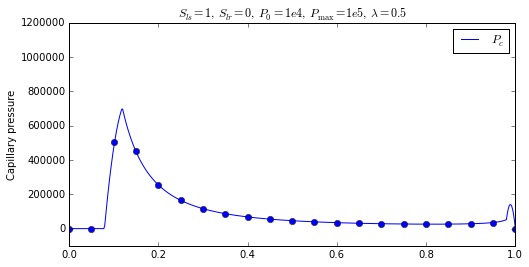

In [526]:
fig, axes = plt.subplots(1,1, figsize = (8,4))
# Case 1
axes.plot(sdata, dpcm1, label = '$P_c$')
axes.plot(dpcvg1.x, dpcvg1.dpc, 'ob')
axes.legend(loc = 'best')
axes.set_ylabel('Capillary pressure')
axes.set_title('$S_{ls}=1, \,S_{lr}=0, \,P_0=1e4, \, P_{\mathrm{max}}=1e5, \,\lambda = 0.5$')
axes.set_ylim([-1e5, 1.2e6]);

Verify that the second derivative of the capillary pressure with respect to liquid saturation is evaluated correctly using the results for case 1 above.

In [527]:
sdata = np.linspace(0,1,500)

d2pcm1 = np.zeros(len(sdata))

for i in xrange(0,len(sdata)) :
    d2pcm1[i] = d2pcvgm(sdata[i], 0, 1, 0.5, 1e4, 1e5)

Read in the data from the MOOSE tests for the van Genuchten capillary pressure.

In [528]:
cols = ('dpc', 'id', 'x', 'y', 'z')
d2pcvg1 = pd.read_csv('gold/CapillaryPressureVanGenuchten_d2pc1_vpp_0001.csv', header = 0, names = cols)

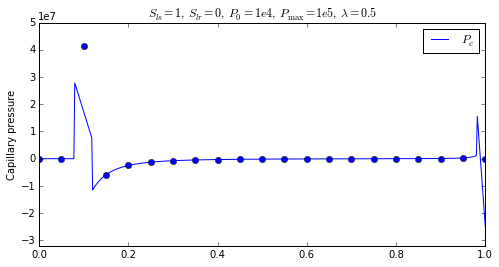

In [529]:
fig, axes = plt.subplots(1,1, figsize = (8,4))
# Case 1
axes.plot(sdata, d2pcm1, label = '$P_c$')
axes.plot(d2pcvg1.x, d2pcvg1.dpc, 'ob')
axes.legend(loc = 'best')
axes.set_ylabel('Capillary pressure')
axes.set_title('$S_{ls}=1, \,S_{lr}=0, \,P_0=1e4, \, P_{\mathrm{max}}=1e5, \,\lambda = 0.5$')
axes.set_ylim([-3.2e7, 5.e7]);